# Lotka-Volterra system with a splitting method of Lie or Strang

> In this example we reuse previous definition in [Lotka-Voleterra resolution with Runge-Kutta method](lotka_volterra_rungekutta.ipynb) which is the first tutorial. In this notebook we solve the same example. 

The system is definied as:

$$
  \begin{aligned}
    \frac{\mathrm{d}x}{\mathrm{d}t} &= \alpha x  - \beta xy \\
    \frac{\mathrm{d}y}{\mathrm{d}t} &= \delta xy - \gamma y \\
  \end{aligned}
$$

where:

* $x$ is the number of prey
* $y$ is the number of predators
* $t$ represents time
* $\alpha$, $\beta$, $\gamma$ and $\delta$ are postive real parameters describing the interaction of the two species.

We would like to compute the invariant $V$ definied by:

$$
  V = \delta x - \gamma \ln(x) + \beta y - \alpha \ln(y)
$$

## Lie or Strang splitting method

An other class of time integrator in Ponio is splitting methods. To use it you need to define each subproblem. In Lotka-Volterra we chose to define this subproblems:

$$
  \varphi^{[1]} = \begin{cases}
    \dot{x} = \alpha x - \beta xy \\
    \dot{y} = 0
  \end{cases} , \qquad
  \varphi^{[2]} = \begin{cases}
    \dot{x} = 0 \\
    \dot{y} = \delta xy - \gamma y
  \end{cases}
$$

The Lie splitting is defined by

$$
  u^{n+1} = \varphi^{[1]}_{\Delta t} \circ \varphi^{[2]}_{\Delta t}(u^n)
$$
where $\varphi^{[i]}_{\Delta t}$ is a solution after time $\Delta t$ on the problem $\varphi^{[i]}$.

The Strang splitting method is defined by

$$
  u^{n+1} = \varphi^{[1]}_{\Delta t/2} \circ \varphi^{[2]}_{\Delta t} \circ \varphi^{[1]}_{\Delta t/2}(u^n)
$$

First we need to define two functions (or objects function):

```cpp
auto phi1 = [=]( double t, state_t const& u ) -> state_t {
    double x = u[0], y = u[1];
    return { alpha*x - beta*x*y , 0. };
};
auto phi2 = [=]( double t, state_t const& u ) -> state_t {
    double x = u[0], y = u[1];
    return { 0. , delta*x*y - gamma*y };
};
```

Now define a `ponio::problem` with `ponio::make_problem`

```cpp
auto pb = ponio::make_problem( phi1, phi2 );
```

To solve it with a Lie or Strang splitting method, we should define a tuple of pairs of methods and time step to say how to solve each sub-problem:

```cpp
auto lie = ponio::splitting::make_lie_tuple(
        std::make_pair(ponio::runge_kutta::rk_44(),0.05),
        std::make_pair(ponio::runge_kutta::rk_33(),0.05)
    );

ponio::solve(pb, lie, u_ini, {0.,tf}, dt, "lotka_volterra_splitting_demo/lie.dat"_fobs);
```

For Strang splitting method, we define a `ponio::strang_tuple` in the same way

```cpp
auto strang = ponio::splitting::make_strang_tuple(
        std::make_pair(ponio::runge_kutta::rk_44(),0.05),
        std::make_pair(ponio::runge_kutta::rk_33(),0.05)
    );

ponio::solve(pb, strang, u_ini, {0.,tf}, dt, "lotka_volterra_splitting_demo/strang.dat"_fobs);
```

In [1]:
%system mkdir -p lotka_volterra_splitting_demo

[]

In [2]:
%%writefile lotka_volterra_splitting_demo/main.cpp

#include <iostream>
#include <valarray>
#include <functional>

#include "ponio/solver.hpp"
#include "ponio/observer.hpp"
#include "ponio/problem.hpp"
#include "ponio/runge_kutta.hpp"

struct Lotka_Voleterra
{
    using state_t = std::valarray<double>;
    double alpha;
    double beta;
    double gamma;
    double delta;
    
    Lotka_Voleterra(double a, double b, double g, double d)
    : alpha(a), beta(b), gamma(g), delta(d)
    {}
    
    state_t phi1(double t, state_t const& u) {
        double x = u[0], y = u[1];
        return { alpha*x - beta*x*y , 0. };
    }
    
    state_t phi2(double t, state_t const& u) {
        double x = u[0], y = u[1];
        return { 0. , delta*x*y - gamma*y };
    }
};

int main()
{
    using state_t = std::valarray<double>;
    using namespace observer;
    using namespace std::placeholders;

    double alpha = 2./3., beta=4./3., gamma=1., delta=1.;
    Lotka_Voleterra lv(alpha,beta,gamma,delta);
    
    auto phi1 = std::bind(&Lotka_Voleterra::phi1, &lv, _1, _2);
    auto phi2 = std::bind(&Lotka_Voleterra::phi2, &lv, _1, _2);
    
    auto pb  = ponio::make_problem(phi1,phi2);

    double dt = 0.1;
    double tf = 100;
    state_t u_ini = {1.8,1.8};
    
    auto lie = ponio::splitting::make_lie_tuple(
        std::make_pair(ponio::runge_kutta::rk_44(),0.05),
        std::make_pair(ponio::runge_kutta::rk_33(),0.05)
    );
    auto strang = ponio::splitting::make_strang_tuple(
        std::make_pair(ponio::runge_kutta::rk_44(),0.05),
        std::make_pair(ponio::runge_kutta::rk_33(),0.05)
    );

    ponio::solve(pb, lie, u_ini, {0.,tf}, dt, "lotka_volterra_splitting_demo/lie.dat"_fobs);
    ponio::solve(pb, strang, u_ini, {0.,tf}, dt, "lotka_volterra_splitting_demo/strang.dat"_fobs);

    return 0;
}

Writing lotka_volterra_splitting_demo/main.cpp


In [3]:
%system $CXX -std=c++20 -I ../include lotka_volterra_splitting_demo/main.cpp -o lotka_volterra_splitting_demo/main

[]

In [4]:
%system ./lotka_volterra_splitting_demo/main

[]

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
data = np.loadtxt("lotka_volterra_splitting_demo/lie.dat")
t_lie = data[:,0]
x_lie = data[:,1]
y_lie = data[:,2]

data = np.loadtxt("lotka_volterra_splitting_demo/strang.dat")
t_strang = data[:,0]
x_strang = data[:,1]
y_strang = data[:,2]

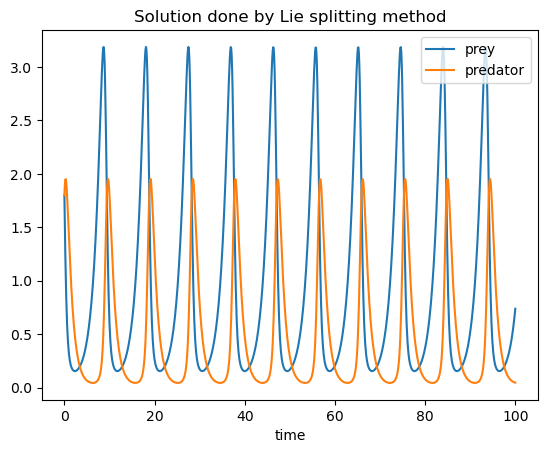

In [7]:
plt.plot(t_lie,x_lie,label="prey")
plt.plot(t_lie,y_lie,label="predator")
plt.xlabel("time")
plt.title("Solution done by Lie splitting method")
plt.legend()
plt.show()

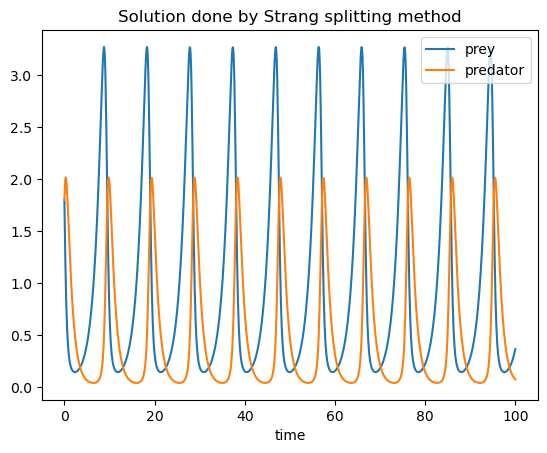

In [8]:
plt.plot(t_strang,x_strang,label="prey")
plt.plot(t_strang,y_strang,label="predator")
plt.xlabel("time")
plt.title("Solution done by Strang splitting method")
plt.legend()
plt.show()

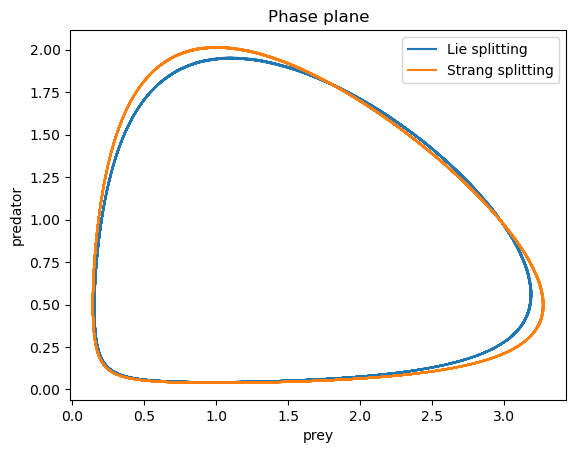

In [9]:
plt.plot(x_lie,y_lie,label="Lie splitting")
plt.plot(x_strang,y_strang,label="Strang splitting")
plt.legend()
plt.xlabel("prey")
plt.ylabel("predator")
plt.title("Phase plane")
plt.show()

Now define the invariant $V$ :
    
$$
  V = \delta x - \ln(x) + \beta y - \alpha \ln(y)
$$

In [10]:
def V(x,y, alpha=2./3., beta=4./3., gamma=1., delta=1.):
    return delta*x - np.log(x) + beta*y - alpha*np.log(y)

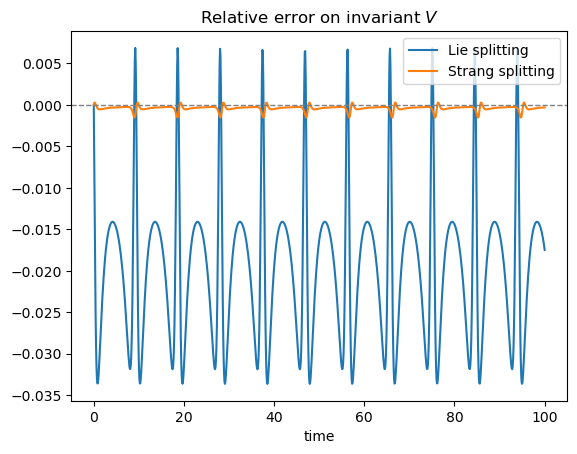

In [11]:
V0 = V(x_lie[0],y_lie[0])
plt.plot(t_lie,V(x_lie,y_lie)/V0-1.,label="Lie splitting")
plt.plot(t_strang,V(x_strang,y_strang)/V0-1.,label="Strang splitting")
plt.axhline(0,0,1,linestyle="--",color="grey",linewidth=1)
plt.title("Relative error on invariant $V$")
plt.xlabel("time")
plt.legend()
plt.show()